# Fine-Tuning Language Models for Text Classification
用于文本分类的微调语言模型

##### FineTuning BERT for Multi-Class Classification with custom datasets

## Preparation for Google Colab

In [ ]:
import os
from google.colab import drive

#  挂载 google 云盘
drive.mount("/content/drive")

print(os.getcwd())  # /content

# print(os.listdir("/content/drive/MyDrive/"))

# print(os.listdir("/content/drive/MyDrive/Colab Notebooks"))

# if os.getcwd() != "/content/drive/MyDrive":
#     os.chdir("/content/drive/MyDrive")

# print(os.getcwd())

In [ ]:
# 提前将 requirements.txt 放在 google 云盘上
!pip install -r /content/drive/MyDrive/requirements.txt

In [3]:
subdir = "ch05c"
work_path = "/content/drive/MyDrive/" + subdir
if not os.path.exists(work_path):
    os.mkdir(work_path)
os.chdir(work_path)
print(os.getcwd())

/content/drive/MyDrive/ch05c


In [4]:
!apt-get install tree && tree -a "./"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
./

0 directories, 0 files


## Obtaining and Preparing downstream task data

In [5]:
if "TTC4900.csv" not in os.listdir():
    !wget  https://raw.githubusercontent.com/savasy/TurkishTextClassification/master/TTC4900.csv
else:
    print("Already there!")

--2025-02-28 07:14:30--  https://raw.githubusercontent.com/savasy/TurkishTextClassification/master/TTC4900.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10627541 (10M) [text/plain]
Saving to: ‘TTC4900.csv’

TTC4900.csv         100%[===================>]  10.13M  19.4MB/s    in 0.5s    

2025-02-28 07:14:31 (19.4 MB/s) - ‘TTC4900.csv’ saved [10627541/10627541]



In [6]:
!tree -a ./

./
└── TTC4900.csv

0 directories, 1 file


In [7]:
!head TTC4900.csv

category,text
siyaset , 3 milyon ile ön seçim vaadi mhp nin 10 olağan büyük kurultayı nda konuşan genel başkan adayı koray_aydın seçimlerden önce partinin üye sayısının 3 milyona ulaştırılması hedefini koyarak ön seçim uygulaması vaadinde bulundu mhp nin 10 olağan büyük kurultayı nda konuşan genel başkan adayı koray_aydın seçimlerden önce partinin üye sayısının 3 milyona ulaştırılması hedefini koyarak ön seçim uygulaması vaadinde bulundu genel_başkan adayı koray_aydın kürsüye beklenirken yapılan tezahüratlar ve ıslıklamalar üzerine divan başkanı tuğrul_türkeş mhp nin genel başkanlığı da genel başkan adaylığı da saygıdeğer işlerdir bu salondaki herkes ciddiye almak zorundadır dedi ve taşkınlıklara izin verilmeyeceğini salonda sükunet sağlanmadan konuşmaların başlamayacağını vurguladı türkeş devlet_bahçeli nin kurultay açılışında konuştuğu için adaylık nedeniyle ikinci bir konuşma yapmayacağını açıkladı konuşmasında kurultayın mhp nin tek başına iktidarına vesile olmasını dileyen aydın a

In [8]:
import pandas as pd

data = pd.read_csv("TTC4900.csv")
data

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...
...,...,...
4895,teknoloji,iphone lara geri dönüyor ios 6 sürümüyle tele...
4896,teknoloji,muslukta devrim sadece elimizi yıkadığımız mu...
4897,teknoloji,halka iyi anlatılmalı bilgi_teknolojileri ile...
4898,teknoloji,çöpe gidiyorlar apple 775 bin uygulamayla app...


In [9]:
data = data.sample(frac=1.0, random_state=42)
data

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...
...,...,...
4426,teknoloji,kuantum bilgisayarlar için dev adım amerikalı...
466,siyaset,koç tan kürt sorunu ile ilgili önemli açıklam...
3092,saglik,her yıl 125 bin bebek prematüre doğuyor türki...
3772,spor,g saray da borç alacak farkı büyük ! galatasa...


In [10]:
data.head(5)

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [11]:
labels = ["teknoloji", "ekonomi", "saglik", "siyaset", "kultur", "spor", "dunya"]
NUM_LABELS = len(labels)
id2label = {i: l for i, l in enumerate(labels)}
label2id = {l: i for i, l in enumerate(labels)}

In [12]:
id2label

{0: 'teknoloji',
 1: 'ekonomi',
 2: 'saglik',
 3: 'siyaset',
 4: 'kultur',
 5: 'spor',
 6: 'dunya'}

In [13]:
label2id

{'teknoloji': 0,
 'ekonomi': 1,
 'saglik': 2,
 'siyaset': 3,
 'kultur': 4,
 'spor': 5,
 'dunya': 6}

In [14]:
data["labels"] = data.category.map(lambda x: label2id[x.strip()])

In [15]:
data.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,5
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,6
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,5


<Axes: ylabel='count'>

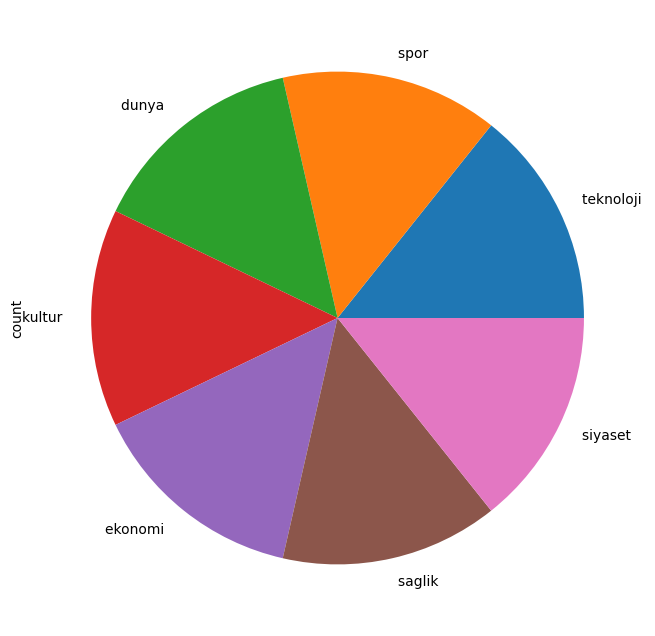

In [16]:
data.category.value_counts().plot(kind="pie", figsize=(8, 8))

## Loading Pre-Trained Model

In [17]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained(
    "dbmdz/bert-base-turkish-uncased", max_length=512
)
tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertTokenizerFast(name_or_path='dbmdz/bert-base-turkish-uncased', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [18]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-uncased",
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Splitting data


In [19]:
data.shape

(4900, 3)

In [20]:
SIZE = data.shape[0]

train_texts = list(data.text[: SIZE // 2])
val_texts = list(data.text[SIZE // 2 : (3 * SIZE) // 4])
test_texts = list(data.text[(3 * SIZE) // 4 :])

train_labels = list(data.labels[: SIZE // 2])
val_labels = list(data.labels[SIZE // 2 : (3 * SIZE) // 4])
test_labels = list(data.labels[(3 * SIZE) // 4 :])

In [21]:
len(train_texts), len(val_texts), len(test_texts)

(2450, 1225, 1225)

In [22]:
len(train_labels), len(val_labels), len(test_labels)

(2450, 1225, 1225)

In [23]:
train_texts[0]

' acıların kedisi sam çatık kaşlı kedi sam in internetteki yükselişi sürüyor sam in kaşlarının boya olmadığı kesinleşirken acıların kedisi görünümle hayvanın instagram hesabı da popülerliliğini artırıyor'

In [24]:
train_labels[0]

0

In [25]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [26]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

In [28]:
len(train_dataset), train_dataset[0]

(2450,
 {'input_ids': tensor([    2, 27058,  1976,  8765,  2478,  3735, 11087,  2042,  2862,  1991,
           8765,  3735,  2092, 13362,  2170,  4108, 28932,  2478,  3304,  2464,
           3735,  2092, 30137, 10779,  5440,  6943,  2958,  3448,  7363,  1024,
           2207, 27058,  1976,  8765,  2478,  8273,  2124,  8983,  1028, 23103,
           9297,  9314,  2020,  4991, 17634,  1024, 30347,  7544, 24402,     3,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,    

## Training with Trainer Class

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)
    return {"Accuracy": acc, "F1": f1, "Precision": precision, "Recall": recall}

In [30]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir="./TTC4900Model",
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",
    # TensorBoard log directory
    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch",
    fp16=True,
    report_to=["tensorboard"]
)
training_args

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=50,
eval_strategy=IntervalStrategy.STEPS,
eval_use

In [31]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer

In [32]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.855700,1.586529,0.595918,0.560133,0.641601,0.594563
100,0.730900,0.351066,0.901224,0.900496,0.902401,0.900876
150,0.446100,0.370966,0.887347,0.886322,0.890800,0.887483
200,0.259300,0.305170,0.913469,0.912641,0.914513,0.914002
250,0.228400,0.304840,0.920816,0.920312,0.920477,0.920495
300,0.197300,0.298449,0.921633,0.921482,0.923522,0.921475
350,0.090200,0.305518,0.926531,0.926011,0.928297,0.925586
400,0.092800,0.323434,0.915102,0.915009,0.916170,0.915104
450,0.094900,0.304280,0.926531,0.925978,0.926116,0.926295


TrainOutput(global_step=462, training_loss=0.43460648374640065, metrics={'train_runtime': 311.3188, 'train_samples_per_second': 23.609, 'train_steps_per_second': 1.484, 'total_flos': 1933953073920000.0, 'train_loss': 0.43460648374640065, 'epoch': 3.0})

In [33]:
!tree -a ./

./
├── multi-class-logs
│   └── events.out.tfevents.1740726976.976c66625ecc.10623.0
├── TTC4900.csv
└── TTC4900Model
    ├── checkpoint-154
    │   ├── config.json
    │   ├── model.safetensors
    │   ├── optimizer.pt
    │   ├── rng_state.pth
    │   ├── scheduler.pt
    │   ├── trainer_state.json
    │   └── training_args.bin
    ├── checkpoint-308
    │   ├── config.json
    │   ├── model.safetensors
    │   ├── optimizer.pt
    │   ├── rng_state.pth
    │   ├── scheduler.pt
    │   ├── trainer_state.json
    │   └── training_args.bin
    └── checkpoint-462
        ├── config.json
        ├── model.safetensors
        ├── optimizer.pt
        ├── rng_state.pth
        ├── scheduler.pt
        ├── trainer_state.json
        └── training_args.bin

5 directories, 23 files


In [34]:
q = [
    trainer.evaluate(eval_dataset=data)
    for data in [train_dataset, val_dataset, test_dataset]
]
pd.DataFrame(q, index=["train", "val", "test"]).iloc[:, :5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.036475,0.991837,0.991810,0.991744,0.991894
val,0.304590,0.926531,0.925939,0.926065,0.926295
test,0.317336,0.928980,0.927900,0.928221,0.927923


In [35]:
def predict(text):
    inputs = tokenizer(
        text, padding=True, truncation=True, max_length=512, return_tensors="pt"
    ).to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(), model.config.id2label[probs.argmax().item()]

In [36]:
# Example #1
text = "Fenerbahçeli futbolcular kısa paslarla hazırlık çalışması yaptılar"
predict(text)

(tensor([[3.1574e-04, 9.2439e-04, 6.8863e-04, 6.5294e-04, 6.5517e-04, 9.9605e-01,
          7.0841e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(5, device='cuda:0'),
 'spor')

## Save and Re-Load saved model for inference

In [37]:
# saving the fine tuned model & tokenizer
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

In [38]:
!tree -a ./

./
├── multi-class-logs
│   ├── events.out.tfevents.1740726976.976c66625ecc.10623.0
│   └── events.out.tfevents.1740727316.976c66625ecc.10623.1
├── TTC4900.csv
├── TTC4900Model
│   ├── checkpoint-154
│   │   ├── config.json
│   │   ├── model.safetensors
│   │   ├── optimizer.pt
│   │   ├── rng_state.pth
│   │   ├── scheduler.pt
│   │   ├── trainer_state.json
│   │   └── training_args.bin
│   ├── checkpoint-308
│   │   ├── config.json
│   │   ├── model.safetensors
│   │   ├── optimizer.pt
│   │   ├── rng_state.pth
│   │   ├── scheduler.pt
│   │   ├── trainer_state.json
│   │   └── training_args.bin
│   └── checkpoint-462
│       ├── config.json
│       ├── model.safetensors
│       ├── optimizer.pt
│       ├── rng_state.pth
│       ├── scheduler.pt
│       ├── trainer_state.json
│       └── training_args.bin
└── turkish-text-classification-model
    ├── config.json
    ├── model.safetensors
    ├── special_tokens_map.json
    ├── tokenizer_config.json
    ├── tokenizer.json
    ├── trai

In [39]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast

model_path = "turkish-text-classification-model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [40]:
nlp("Sinemada hangi filmler oynuyor bugün")

[{'label': 'kultur', 'score': 0.993539035320282}]

In [41]:
nlp("Dolar ve Euro bugün yurtiçi piyasalarda yükseldi")

[{'label': 'ekonomi', 'score': 0.9931417107582092}]

In [42]:
nlp(
    "Bayern Münih ile Barcelona bugün karşı karşıya geliyor. Maçı İngiliz hakem James Watts yönetecek!"
)

[{'label': 'spor', 'score': 0.996451735496521}]